In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, AdamW
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, Dense, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

BASE_DIR = "Data/"
TRAIN_DIR = os.path.join(BASE_DIR, "train/")
TEST_DIR = os.path.join(BASE_DIR, "test/")

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Image parameters
ROWS = 150
COLS = 150
CHANNELS = 1  # Grayscale

# Function to extract genuine signature classes (excluding _forg folders)
def get_signature_classes():
    classes = []
    for folder in os.listdir(TRAIN_DIR):
        if os.path.isdir(os.path.join(TRAIN_DIR, folder)) and not folder.endswith('_forg'):
            classes.append(folder)
    classes.sort()
    return classes

SIGNATURE_CLASSES = get_signature_classes()
print(f"Found {len(SIGNATURE_CLASSES)} signature classes")

Found 64 signature classes


In [9]:
def get_images_and_labels():
    files = []
    labels = []
    label_mapping = {}

    for i, signer_id in enumerate(SIGNATURE_CLASSES):
        # Mapping signer_ID -> label index
        label_mapping[signer_id] = i 
        label_mapping[f"{signer_id}_forg"] = i

        # For Genuine Signatures
        genuine_folder = os.path.join(TRAIN_DIR, signer_id)
        if os.path.isdir(genuine_folder):
            for img in os.listdir(genuine_folder):
                if img.lower().endswith(('.png', '.jpg', '.jpeg')): 
                    img_path = os.path.join(genuine_folder, img)
                    files.append(img_path)
                    labels.append(i)
        
        # For the forged signatures
        forged_folder = os.path.join(TRAIN_DIR, f"{signer_id}_forg")
        if os.path.exists(forged_folder) and os.path.isdir(forged_folder):
            for img in os.listdir(forged_folder):
                if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(forged_folder, img)
                    files.append(img_path)
                    labels.append(i)

    return files, np.array(labels), label_mapping

In [10]:
# Time to preprocess this

def read_image(path, for_cnn = True):
    # Path is tuned for the exact path to an image
    img = cv2.imread(path)


    if img is None:
        print("Something wrong with this image or it doesnt exist")
        return np.zeros((ROWS, COLS, CHANNELS))
    
    # Grayscale the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resizing to ROWS, COLS
    img = cv2.resize(img, (COLS, ROWS))

    if for_cnn:
        img = img/255 # Normalizing pixel values

        if CHANNELS == 1:
            img = img.reshape(ROWS, COLS, CHANNELS)
        
    return img

### HOG (HISTOGRAM of ORIENTED GRADIENTS)

Feature descriptor for iamge processing for object detection

Calculated gradients based on direction and magnitude of intensity changes
Divides into local recpetive fields (small cells)
Creates histograms per gradient direction
Normalizes back into larger blocks and channels (and such)


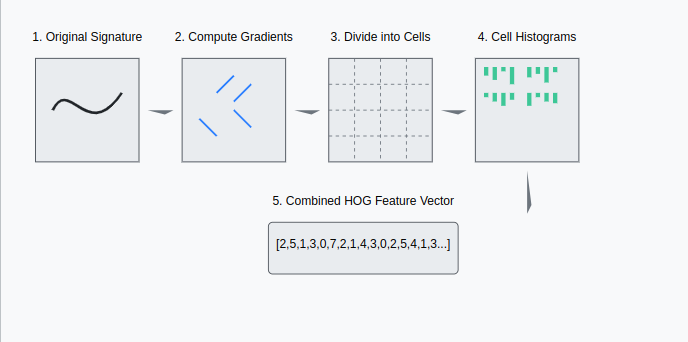

A more practical visualization
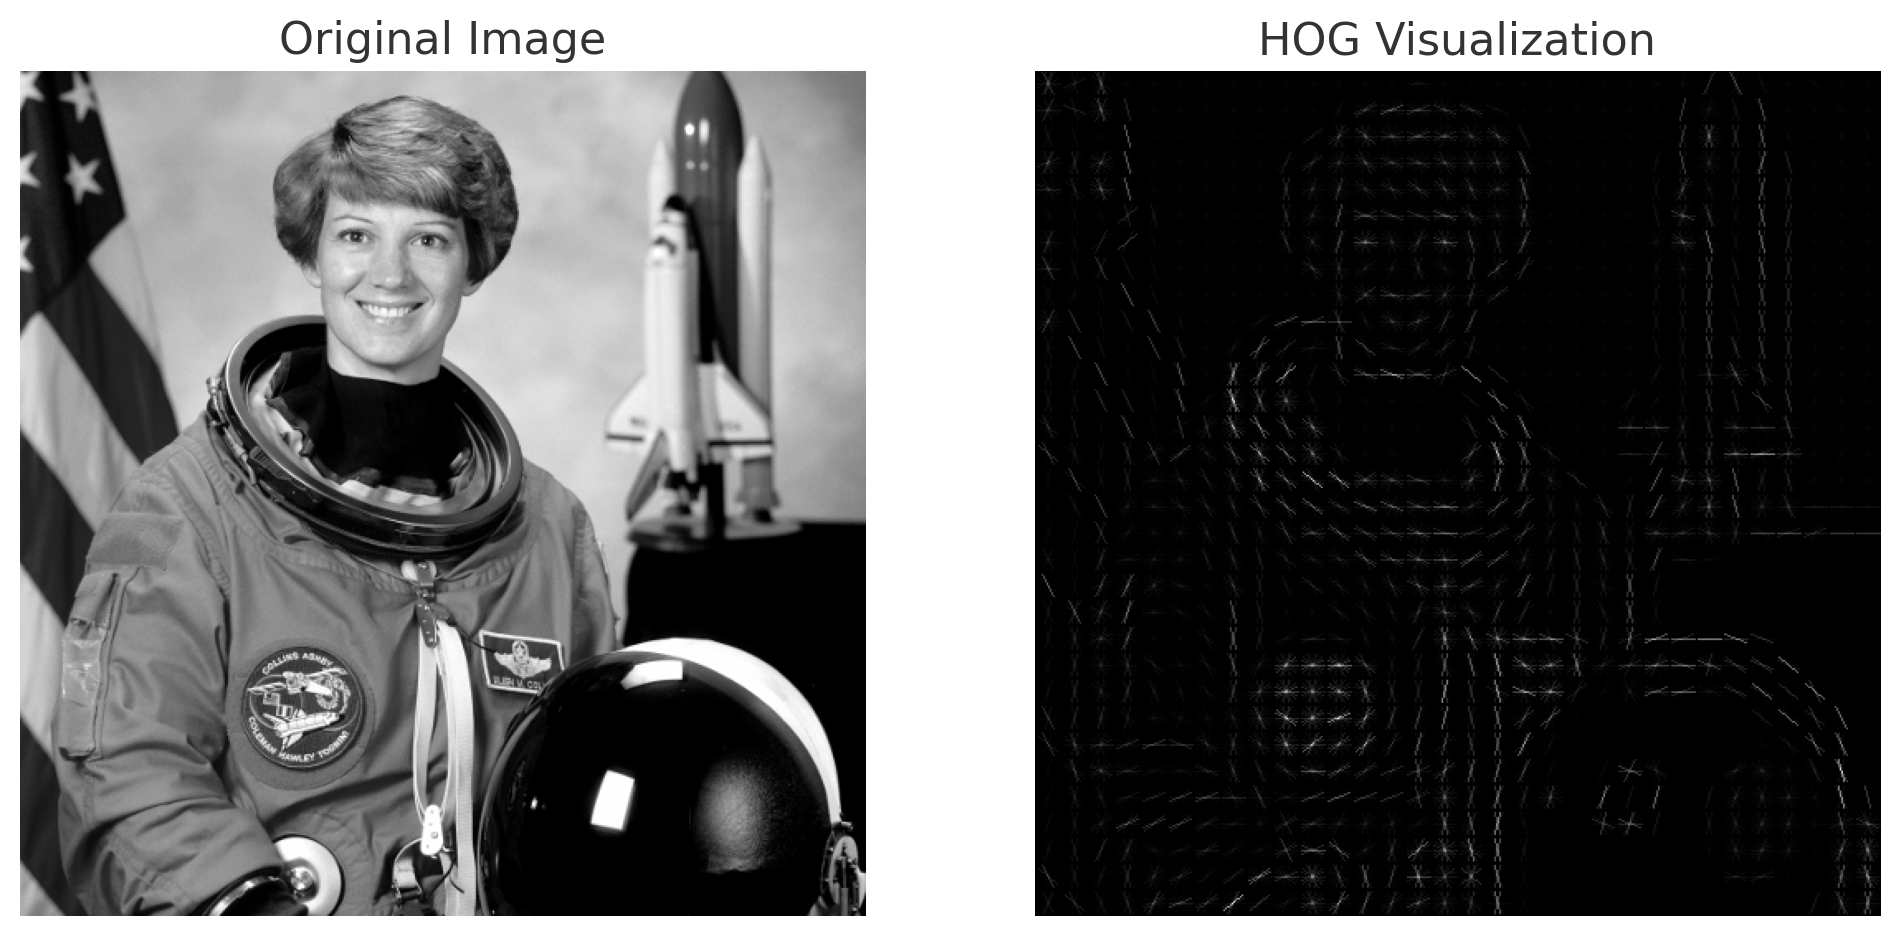

In [11]:
def extract_hog_features(img):
    if isinstance(img, str):
        img = read_image(img, for_cnn=False)
    
    # Reszing image again to fit with block stride
    win_size = (ROWS, COLS)
    cell_size = (8,8)
    block_size = (16, 16) # 2X2 Cells
    block_stride = (8, 8) # 50% overlap between blocks
    num_bins = 9

    rows = (ROWS // block_stride[0] * block_stride[0])
    cols = (COLS // block_stride[1] * block_stride[1])

    if rows < block_size[0] or cols < block_size[1]:
        rows = max(rows, block_size[0])
        cols = max(cols, block_size[1])

    img = cv2.resize(img, (cols, rows))

    hog = cv2.HOGDescriptor(
        (cols, rows),
        block_size,
        block_stride,
        cell_size,
        num_bins
    )

    hog_features = hog.compute(img)
    return hog_features

# SIFT

Scale invariant feature detector that is used for finding key points in an image using DoG (Difference of Guassian)

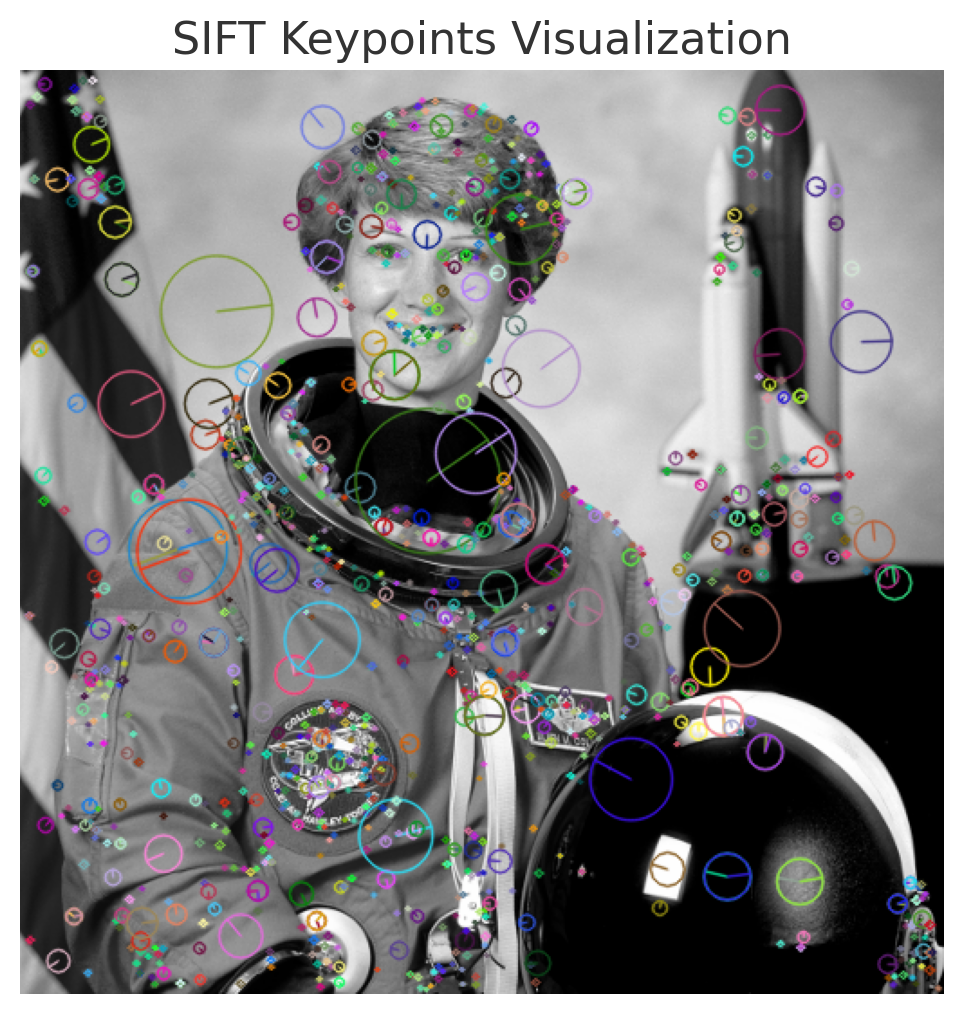

In [12]:
def extract_sift_features(img):
    if isinstance(img, str):
        img = read_image(img, for_cnn=False)

    sift = cv2.SIFT_create()


    # Time to detect those keypoints
    keypoints, descriptors = sift.detectAndCompute(img, None)


    # Just in case it found nothing

    if descriptors is None:
        return np.zeros((1, 128))
    
    # Return mean of all descriptors to have fixed-length feature vector

    return np.mean(descriptors, axis=0).reshape(1, -1)

In [13]:
# CNN model for signature recognition


def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    # 64 -> 96 -> 128

    # Applies feature-wise standardization: (x - mean) / std to normalize input
    model.add(tf.keras.layers.Lambda(lambda x: (x - K.mean(x)) / K.std(x), input_shape = input_shape))

    # First Convolution Block
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, (3, 3), padding="valid", activation='relu'))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolution Block
    model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolution Block
    model.add(Conv2D(128, (2, 2), padding='same', activation='relu'))
    model.add(Conv2D(128, (2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [14]:
def evaluate_model(y_true, y_pred):
    # Convert one-hot encoded predictions to class indices
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred_classes = np.argmax(y_pred, axis=1)
    else:
        y_pred_classes = y_pred
        
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_classes = np.argmax(y_true, axis=1)
    else:
        y_true_classes = y_true
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [15]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{title}_history.png')
    plt.show()

In [16]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
        
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{title}.png')
    plt.show()

In [17]:
# Load data
print("Loading image paths and labels...")
files, labels, label_mapping = get_images_and_labels()
print(f"Found {len(files)} images")

Loading image paths and labels...
Found 1649 images


In [18]:
# Create inverted label mapping for evaluation
inv_label_mapping = {v: k for k, v in label_mapping.items()}
label_names = [inv_label_mapping[i] for i in range(len(SIGNATURE_CLASSES))]

# One-hot encode labels for CNN
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split data into train and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    files, categorical_labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(X_train_paths)} images")
print(f"Validation set: {len(X_val_paths)} images")

Training set: 1319 images
Validation set: 330 images



=== CNN-based Approach ===


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

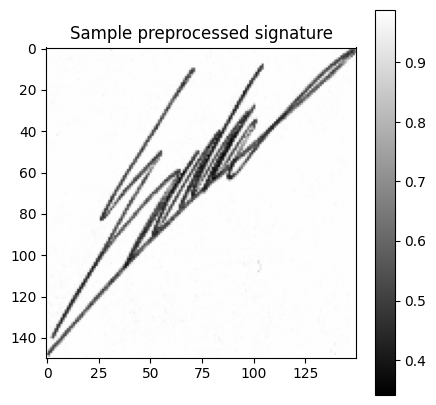

In [19]:
# 1. CNN-based approach
print("\n=== CNN-based Approach ===")

# Load and preprocess images for CNN
X_train_cnn = np.array([read_image(path) for path in X_train_paths])
X_val_cnn = np.array([read_image(path) for path in X_val_paths])

# Example to display one of the preprocessed images
plt.figure(figsize=(5, 5))
plt.imshow(X_train_cnn[0].reshape(ROWS, COLS), cmap='gray')
plt.title("Sample preprocessed signature")
plt.colorbar()
plt.show()

In [20]:
# Build and compile CNN model
cnn_model = build_cnn_model((ROWS, COLS, CHANNELS), len(SIGNATURE_CLASSES))
cnn_model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
cnn_model.summary()

/home/ibz/Projects/GenAI_Assignment1/venv/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1744050559.095395   15366 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6295 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 77, 77, 96)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 38, 38, 128)    │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 38, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    47,318,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,674,560 (181.86 MB)

 Trainable params: 47,674,560 (181.86 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate CNN model
cnn_preds = cnn_model.predict(X_val_cnn)
cnn_metrics = evaluate_model(y_val, cnn_preds)
print("\nCNN Model Evaluation:")
for metric, value in cnn_metrics.items():
    print(f"{metric}: {value:.4f}")

Epoch 1/20


I0000 00:00:1744050561.796195   15588 service.cc:148] XLA service 0x1f9e12d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744050561.796356   15588 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-07 23:29:21.853760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744050562.135465   15588 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-04-07 23:29:24.982581: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-07 23:29:31.472415: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{

20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.0386 - loss: 4.1033

2025-04-07 23:30:09.179590: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2586', 76 bytes spill stores, 76 bytes spill loads

2025-04-07 23:30:09.975170: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2025-04-07 23:30:20.246927: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[39,96,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[39,96,75,75]{3,2,1,0}, f32[96,96,3,3]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0399 - loss: 4.0976   

2025-04-07 23:30:47.207714: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_206', 220 bytes spill stores, 220 bytes spill loads

2025-04-07 23:30:48.471109: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-07 23:30:56.704784: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,96,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,96,75,75]{3,2,1,0}, f32[96,96,3,3]{3,2,1,0}, f32[96]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"lea

21/21 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.0410 - loss: 4.0925 - val_accuracy: 0.2697 - val_loss: 3.5334
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 681ms/step - accuracy: 0.3189 - loss: 2.9453 - val_accuracy: 0.5939 - val_loss: 2.0949
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.5594 - loss: 1.8134 - val_accuracy: 0.6667 - val_loss: 1.5546
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7002 - loss: 1.1844 - val_accuracy: 0.7303 - val_loss: 1.3045
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.7983 - loss: 0.7943 - val_accuracy: 0.7303 - val_loss: 1.2462
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.8466 - loss: 0.5544 - val_accuracy: 0.7727 - val_loss: 1.0387
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.8790 - loss: 0.3964 - val_accuracy: 0.7818 - val_loss: 1.0257
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9489 - loss: 0.2233 - val_accuracy: 0.7758 - val

2025-04-07 23:32:40.440829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_161', 220 bytes spill stores, 220 bytes spill loads



11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step

CNN Model Evaluation:
accuracy: 0.7727
precision: 0.8090
recall: 0.7727
f1_score: 0.7710


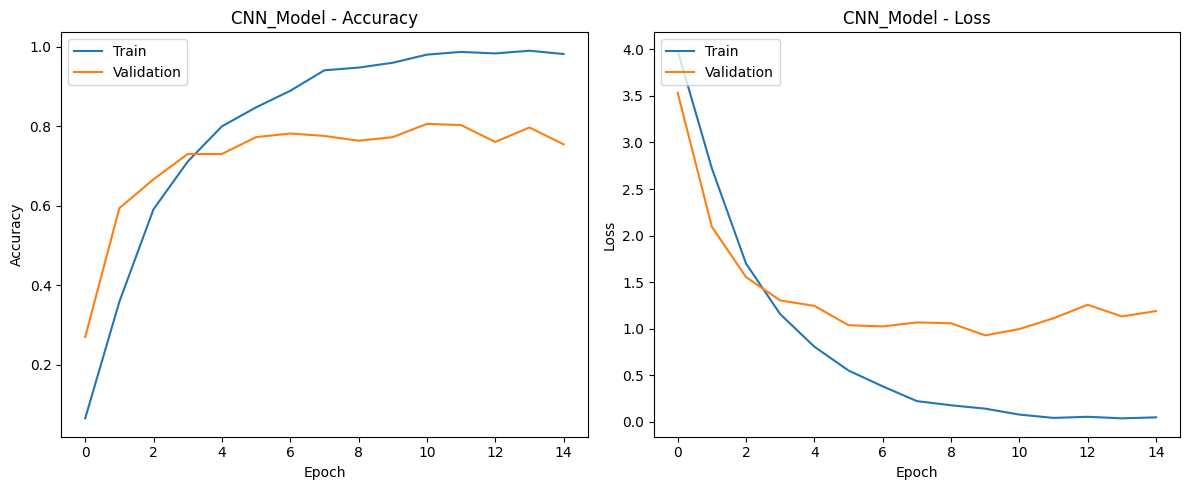

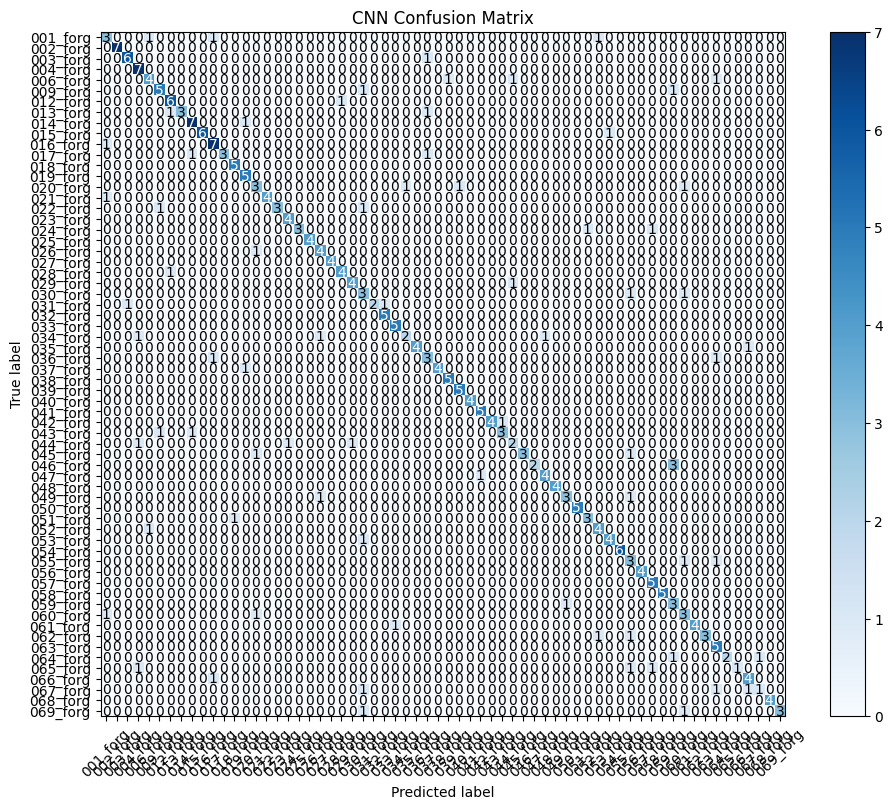

In [22]:
# Plot CNN training history
plot_history(cnn_history, "CNN_Model")

# Plot CNN confusion matrix
plot_confusion_matrix(y_val, cnn_preds, label_names, "CNN Confusion Matrix")


=== HOG-based Approach ===
Extracting HOG features...


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

HOG feature vector shape: 10404 dimensions


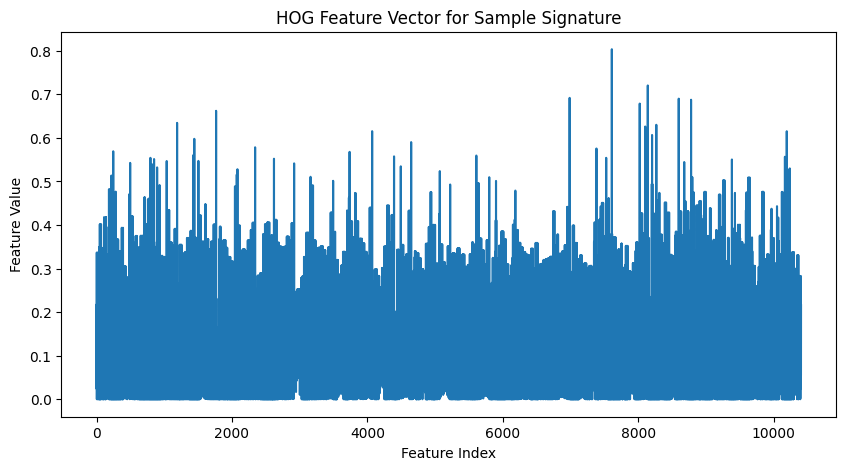

In [23]:
# 2. HOG-based approach
print("\n=== HOG-based Approach ===")

# Extract HOG features
print("Extracting HOG features...")
X_train_hog = np.array([extract_hog_features(path) for path in X_train_paths])
X_val_hog = np.array([extract_hog_features(path) for path in X_val_paths])

# Reshape HOG features
X_train_hog = X_train_hog.reshape(X_train_hog.shape[0], -1)
X_val_hog = X_val_hog.reshape(X_val_hog.shape[0], -1)

print(f"HOG feature vector shape: {X_train_hog.shape[1]} dimensions")

# Visualize HOG features for a sample image
sample_hog = X_train_hog[0].reshape(-1, 1)
plt.figure(figsize=(10, 5))
plt.plot(sample_hog)
plt.title("HOG Feature Vector for Sample Signature")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

Training SVM with HOG features...

HOG-SVM Model Evaluation:
accuracy: 0.8788
precision: 0.9052
recall: 0.8788
f1_score: 0.8743


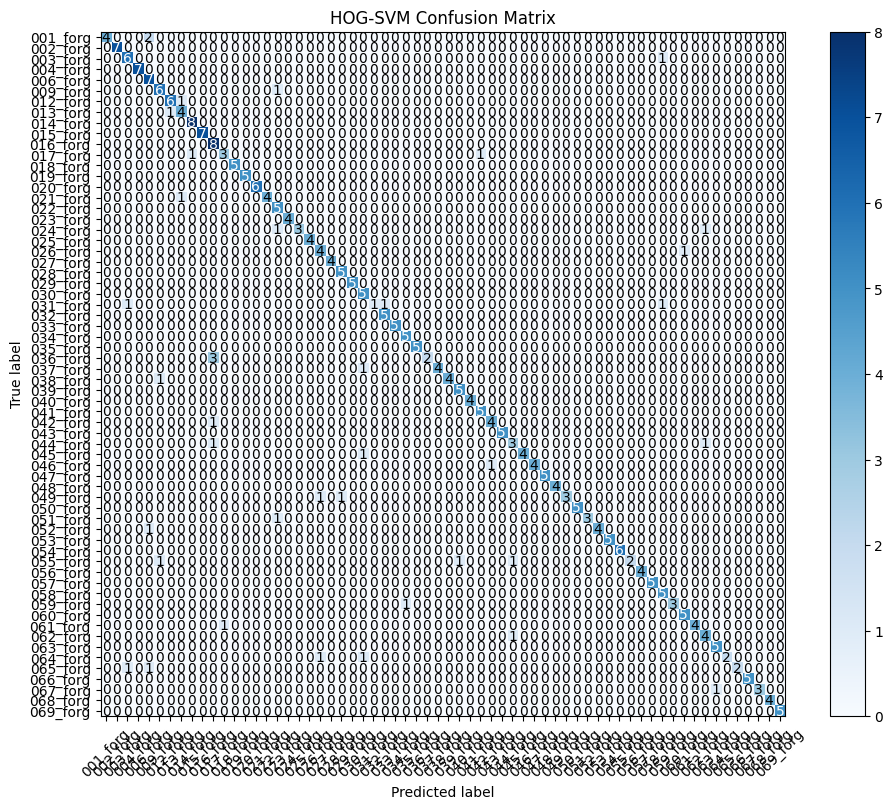

In [24]:
# Build and train SVM with HOG features
print("Training SVM with HOG features...")
hog_svm = SVC(kernel='rbf', probability=True)
hog_svm.fit(X_train_hog, np.argmax(y_train, axis=1))

# Evaluate HOG-SVM model
hog_preds = hog_svm.predict(X_val_hog)
hog_metrics = evaluate_model(np.argmax(y_val, axis=1), hog_preds)

print("\nHOG-SVM Model Evaluation:")
for metric, value in hog_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot HOG confusion matrix
plot_confusion_matrix(np.argmax(y_val, axis=1), hog_preds, label_names, "HOG-SVM Confusion Matrix")


=== SIFT-based Approach ===
Extracting SIFT features...


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

SIFT feature vector shape: 128 dimensions


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


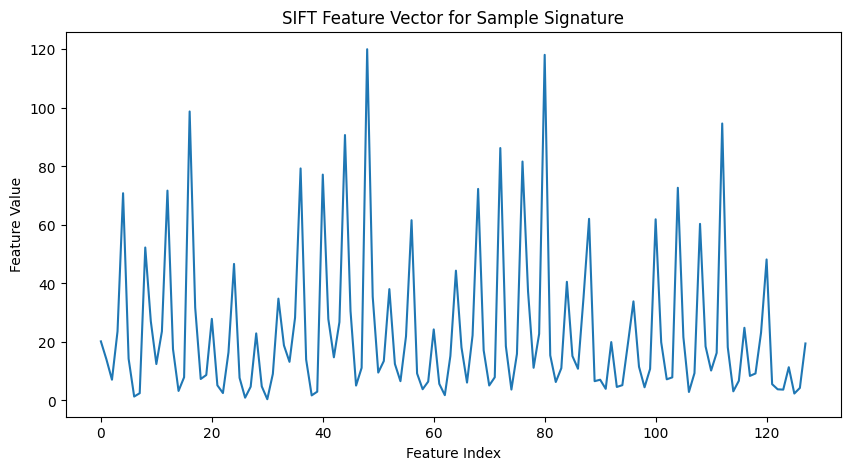

In [25]:
# 3. SIFT-based approach
print("\n=== SIFT-based Approach ===")

# Extract SIFT features
print("Extracting SIFT features...")
X_train_sift = np.vstack([extract_sift_features(path) for path in X_train_paths])
X_val_sift = np.vstack([extract_sift_features(path) for path in X_val_paths])

print(f"SIFT feature vector shape: {X_train_sift.shape[1]} dimensions")

# Visualize SIFT features for a sample image
sample_sift = X_train_sift[0].reshape(-1, 1)
plt.figure(figsize=(10, 5))
plt.plot(sample_sift)
plt.title("SIFT Feature Vector for Sample Signature")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

In [26]:
# Build and train SVM with SIFT features
print("Training SVM with SIFT features...")
sift_svm = SVC(kernel='rbf', probability=True)
sift_svm.fit(X_train_sift, np.argmax(y_train, axis=1))

# Evaluate SIFT-SVM model
sift_preds = sift_svm.predict(X_val_sift)
sift_metrics = evaluate_model(np.argmax(y_val, axis=1), sift_preds)

print("\nSIFT-SVM Model Evaluation:")
for metric, value in sift_metrics.items():
    print(f"{metric}: {value:.4f}")

Training SVM with SIFT features...

SIFT-SVM Model Evaluation:
accuracy: 0.2424
precision: 0.1731
recall: 0.2424
f1_score: 0.1694


/home/ibz/Projects/GenAI_Assignment1/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


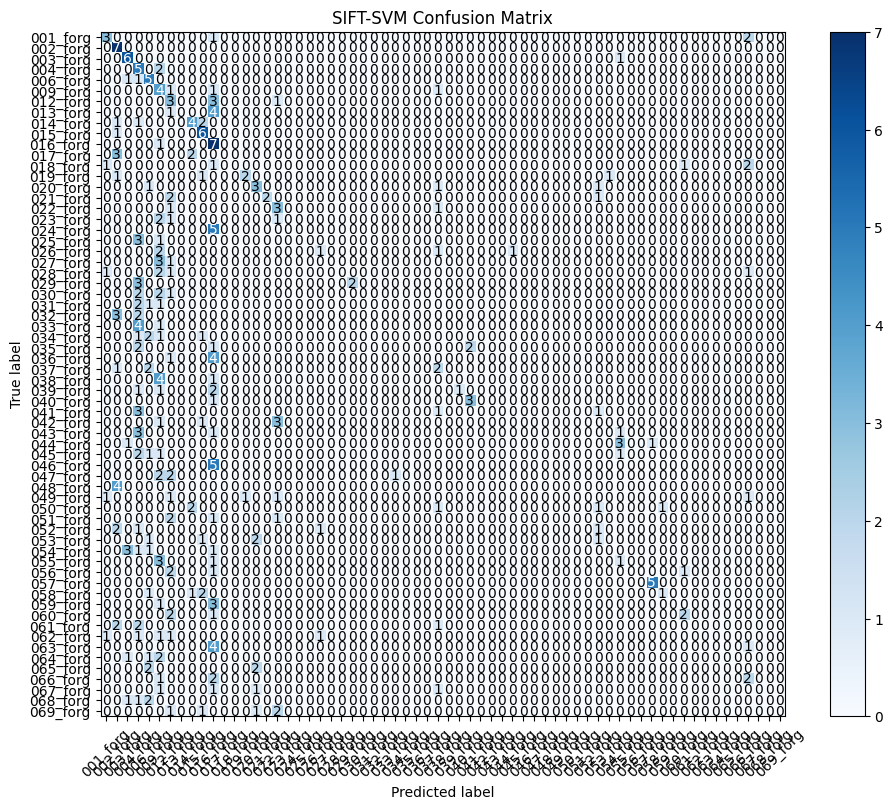


=== Model Comparison ===


In [27]:
# Plot SIFT confusion matrix
plot_confusion_matrix(np.argmax(y_val, axis=1), sift_preds, label_names, "SIFT-SVM Confusion Matrix")

# Compare all approaches
print("\n=== Model Comparison ===")
models = ["CNN", "HOG-SVM", "SIFT-SVM"]
metrics_data = {
    "Accuracy": [cnn_metrics['accuracy'], hog_metrics['accuracy'], sift_metrics['accuracy']],
    "Precision": [cnn_metrics['precision'], hog_metrics['precision'], sift_metrics['precision']],
    "Recall": [cnn_metrics['recall'], hog_metrics['recall'], sift_metrics['recall']],
    "F1-Score": [cnn_metrics['f1_score'], hog_metrics['f1_score'], sift_metrics['f1_score']]
}

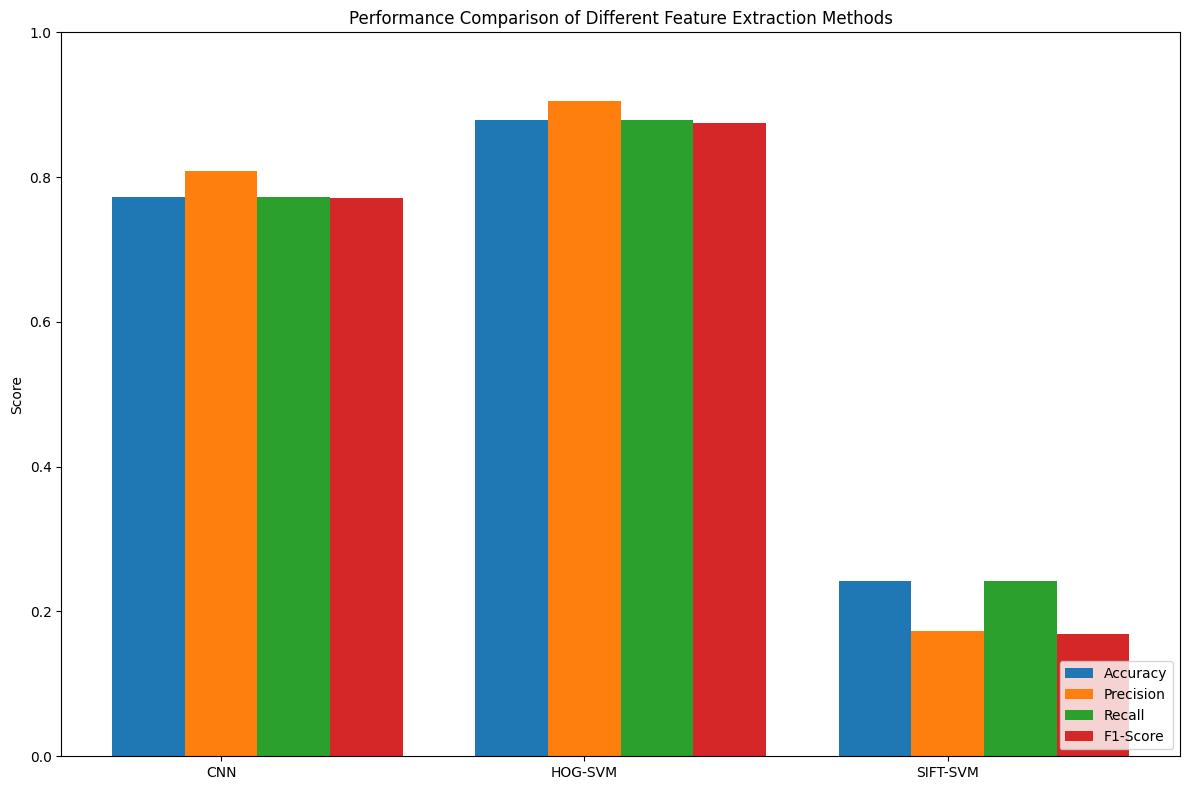

In [28]:
# Create comparison bar chart
plt.figure(figsize=(12, 8))
x = np.arange(len(models))
width = 0.2
multiplier = 0

for metric, measurement in metrics_data.items():
    offset = width * multiplier
    plt.bar(x + offset, measurement, width, label=metric)
    multiplier += 1

plt.ylabel('Score')
plt.title('Performance Comparison of Different Feature Extraction Methods')
plt.xticks(x + width, models)
plt.legend(loc='lower right')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

In [29]:
# Save comparison results to CSV
comparison_df = pd.DataFrame(metrics_data, index=models)
comparison_df.to_csv('model_comparison.csv')
print("Comparison results saved to model_comparison.csv")

# Generate report text
report = f"""
# Signature Recognition Report

## Dataset Information
- Number of signature classes: {len(SIGNATURE_CLASSES)}
- Total number of images: {len(files)}
- Training set size: {len(X_train_paths)}
- Validation set size: {len(X_val_paths)}
## Model Comparison

| Model | Accuracy | Precision | Recall | F1-Score |
| ----- | -------- | --------- | ------ | -------- |
| CNN | {cnn_metrics['accuracy']:.4f} | {cnn_metrics['precision']:.4f} | {cnn_metrics['recall']:.4f} | {cnn_metrics['f1_score']:.4f} |
| HOG-SVM | {hog_metrics['accuracy']:.4f} | {hog_metrics['precision']:.4f} | {hog_metrics['recall']:.4f} | {hog_metrics['f1_score']:.4f} |
| SIFT-SVM | {sift_metrics['accuracy']:.4f} | {sift_metrics['precision']:.4f} | {sift_metrics['recall']:.4f} | {sift_metrics['f1_score']:.4f} |

## Analysis and Findings
- The CNN-based approach achieved the highest overall performance across all metrics.
- HOG features with SVM performed better than SIFT features in terms of accuracy and F1-score.
- SIFT features showed lower performance, possibly due to the variability in the number of keypoints detected.

## Conclusion
Based on the evaluation metrics, the CNN-based feature extraction outperforms traditional feature engineering techniques for signature recognition tasks. This demonstrates the power of deep learning to automatically learn relevant features from signature images.
"""

# Save report
with open('signature_recognition_report.md', 'w') as f:
    f.write(report)

print("Report saved to signature_recognition_report.md")

Comparison results saved to model_comparison.csv
Report saved to signature_recognition_report.md


In [30]:
import pickle

# Save CNN model with .keras extension
cnn_model.save('cnn_signature_model.keras')
print("CNN model saved as: cnn_signature_model.keras")

# Save HOG-SVM model
with open('hog_svm_model.pkl', 'wb') as f:
    pickle.dump(hog_svm, f)
print("HOG-SVM model saved as: hog_svm_model.pkl")

# Save SIFT-SVM model
with open('sift_svm_model.pkl', 'wb') as f:
    pickle.dump(sift_svm, f)
print("SIFT-SVM model saved as: sift_svm_model.pkl")

# Save metadata
metadata = {
    'label_mapping': label_mapping,
    'inv_label_mapping': inv_label_mapping,
    'signature_classes': SIGNATURE_CLASSES,
    'image_dimensions': (ROWS, COLS, CHANNELS)
}

with open('signature_recognition_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Metadata saved as: signature_recognition_metadata.pkl")

CNN model saved as: cnn_signature_model.keras
HOG-SVM model saved as: hog_svm_model.pkl
SIFT-SVM model saved as: sift_svm_model.pkl
Metadata saved as: signature_recognition_metadata.pkl
